<a href="https://colab.research.google.com/github/ericburdett/cs474_labs_f2019/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ericburdett/cs474_labs_f2019/blob/master/DL_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Intro to PyTorch

## Deliverable

For this lab, you will submit an ipython notebook via learningsuite.
This lab will be mostly boilerplate code, but you will be required to implement a few extras.

**NOTE: you almost certainly will not understand most of what's going on in this lab!
That's ok - the point is just to get you going with pytorch.
We'll be working on developing a deeper understanding of every part of this code
over the course of the next two weeks.**

A major goal of this lab is to help you become conversant in working through pytorch
tutorials and documentation.
So, you should feel free to google whatever you want and need!

This notebook will have three parts:

* Part 1: Your notebook should contain the boilerplate code. See below.

* Part 2: Your notebook should extend the boilerplate code by adding a testing loop.

* Part 3: Your notebook should extend the boilerplate code by adding a visualization of test/training performance over time.

The resulting image could, for example, look like this:
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?cache=&w=900&h=608&tok=3092fe&media=cs501r_f2018:lab2.png)
See the assigned readings for pointers to documentation on pytorch.
___

### Grading standards:
Your notebook will be graded on the following:

* 50% Successfully followed lab video and typed in code
* 20% Modified code to include a test/train split
* 20% Modified code to include a visualization of train/test losses
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Description
Throughout this class, we will be using pytorch to implement our deep neural networks. 
Pytorch is a deep learning framework that handles the low-level details of 
GPU integration and automatic differentiation.

The goal of this lab is to help you become familiar with pytorch. 
The three parts of the lab are outlined above.

For part 1, you should watch the video below, and type in the code as it is explained to you.

A more detailed outline of Part 1 is below.

For part 2, you must add a validation (or testing) loop using the 
FashionMNIST dataset with train=False

For part 3, you must plot the loss values and demonstrate overfitting.

The easiest way to do this is to limit the size of your training dataset 
so that it only returns a single batch (ie len(dataloader) == batch_size, 
and train for multiple epochs. In the example graph above, 
I set my batch size to 42, and augmented my dataloader to produce only 42 
unique items by overwriting the len function to return 42. 
In my training loop, I performed a validation every epoch which basically corresponded 
to a validation every step.

In practice, you will normally compute your validation loss every n steps, 
rather than at the end of every epoch. This is because some epochs can take hours, 
or even days and you don’t often want to wait that long to see your results.

Testing your algorithm by using a single batch and training until overfitting 
is a great way of making sure that your model and optimizer are working the way they should!

___

### Part 0
Watch Tutorial Video

[https://youtu.be/0P-YctShbwc](https://youtu.be/0P-YctShbwc)

**TODO:**


**DONE:**
* Watch video
___

### Part 1
Your notebook should contain the boilerplate code. See below.

**TODO:**



**DONE:**
* Replicate boilerplate from the video
___

### Part 2
Your notebook should extend the boilerplate code by adding a testing loop.

**TODO:**



**DONE:**
* Add a testing (validation) loop

In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

# Boilerplate code from the video
class LinearNetwork(nn.Module):
  def __init__(self, dataset, in_dim, out_dim):
    super(LinearNetwork, self).__init__()
    self.net = nn.Sequential(nn.Linear(in_dim, 100),
                            nn.ReLU(),
                            nn.ReLU(),
                            nn.ReLU(),
                            nn.ReLU(),
                            nn.ReLU(),
                            nn.Linear(100, out_dim))
    
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c * h * w)
    return self.net(flattened)

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root,
                                     train=train,
                                     transform=transforms.ToTensor(),
                                     download=True)
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    # Consider modifying this value for future parts
    return 20 #len(self.data)
  
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
model = LinearNetwork(train_dataset, 784, 10)
model = model.cuda()
objective = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset,
                          batch_size=20,
                          pin_memory=True)

# Dataset used for testing/validation
test_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
test_loader = DataLoader(test_dataset,
                        batch_size=20,
                        pin_memory=True)

train_losses = []
test_losses = []

loop = tqdm(total=100, position=0)

# Perform 100,000 epochs
for epoch in range(100000):
  for x, y in train_loader:
    #Training for each value in the train loader for every epoch
    train_x, train_y = x.cuda(async=True), y.cuda(async=True)
    optimizer.zero_grad()
    
    train_y_hat = model(train_x)
    train_loss = objective(train_y_hat, train_y)
    
    train_loss.backward()
    optimizer.step()
  
  if epoch % 100 == 0:
    # Only keep track of our training loss once per 100 epochs
    train_losses.append(train_loss.item())
    
    # Only calculate our testing loss and keep track of that data once per 100 epochs
    test_x, test_y = next(iter(test_loader))
    test_x, test_y = test_x.cuda(async=True), test_y.cuda(async=False)
    test_y_hat = model(test_x)

    test_loss = objective(test_y_hat, test_y)
    test_losses.append(test_loss.item())
    
    # Only update the display for every percent completed
    if epoch % 1000 == 0:
      loop.set_description('Training Loss:{:.4f}'.format(train_loss.item()) + ' Testing Loss:{:.4f}'.format(test_loss.item()))
      loop.update(1)

loop.close()

Training Loss:0.0641 Testing Loss:1.6661: 100%|██████████| 100/100 [06:06<00:00,  3.68s/it]


___

### Part 3
Your notebook should extend the boilerplate code by adding a visualization of test/training
performance over time. Use matplotlib.pyplot

**TODO:**


**DONE:**
* Add a visualization of test/train performance (i.e. loss) over time.

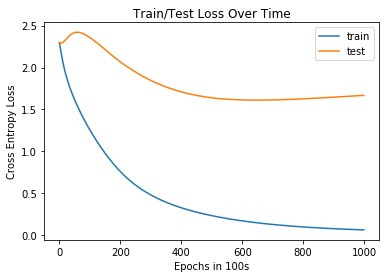

In [38]:
# Code runs above that populates loss data for this graph
# Note that x-axis is epochs in 100's meaning that there are 100,000 total epochs performed

# This plot shows a batch size of 15 over 100,000 epochs. We can see some overfitting here.
# However, if we increase the number of epochs and decrease the batch_size and training data,
# we will start to see the validation/testing data get worse and worse over time while the
# training data moves towards zero.

# On the other hand, increasing the batch size and limiting the number of epochs will discourage
# overfitting, and our test/validation loss will more closely resemble our training loss.

plt.plot(range(0,1000), train_losses, label='train')
plt.plot(range(0,1000), test_losses, label='test')
plt.xlabel('Epochs in 100''s')
plt.ylabel('Cross Entropy Loss')
plt.title('Train/Test Loss Over Time')
plt.legend()